In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
import tmap as tm

### 1. Load dataset

In [2]:
url = "https://raw.githubusercontent.com/DIFACQUIM/Art-Driven-by-Visual-Representations-of-Chemical-Space-/main/Datasets/02_wine_notes_16JUNE2023.csv"
DATA = pd.read_csv(url)
DATA.head(2)

,COMPOUND_ID,NAME_FOOD_DB,NEW_SMILES,FLAVOR_ID,NAME_FLAVOR,FLAVOR_GROUP
0,373,Prenyl acetate,CC(=O)OCC=C(C)C,71.0,banana,fruity
1,411,Geranyl 3-methylbutanoate,CC(C)=CCCC(C)=CCOC(=O)CC(C)C,69.0,apple,fruity


In [3]:
set(list(DATA["FLAVOR_GROUP"]))

{'floral', 'fruity'}

### 2. Show overlapping compounds

Text(0.5, 0.98, 'COMPOUNDS')

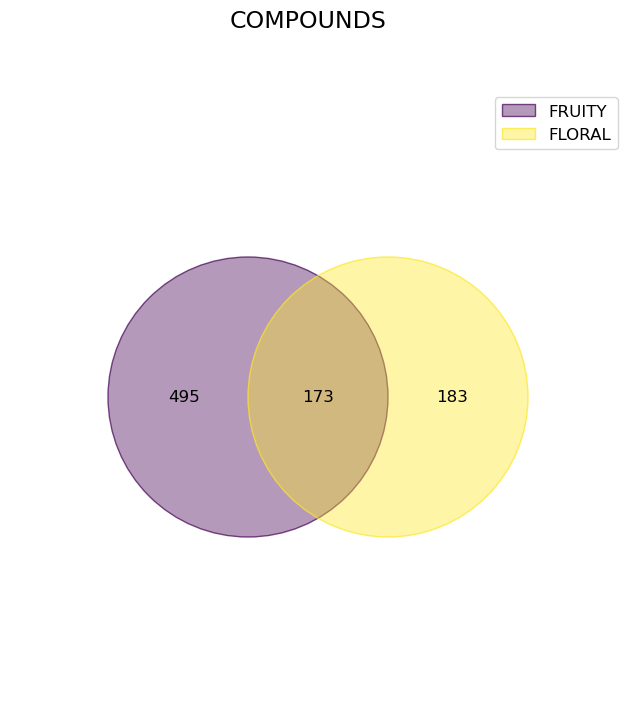

In [4]:
from venn import venn
import matplotlib.pyplot as plt
# Split dataset
FRUITY = DATA[DATA["FLAVOR_GROUP"]==str('fruity')]
FLORAL = DATA[DATA["FLAVOR_GROUP"]==str('floral')]

# Generate venn diagram
COMPOUNDS = {"FRUITY":set(FRUITY["NEW_SMILES"]),
             "FLORAL":set(FLORAL["NEW_SMILES"])
             }
COMPOUNDS = venn(COMPOUNDS, fontsize=12)
plt.suptitle("COMPOUNDS", fontsize=17)

In [5]:
# Show initial labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'fruity', 'floral'}


In [6]:
# Generate new labels of overlapping compounds
FinalSet = []
for name, group in DATA.groupby(["NEW_SMILES"]):
    label = list(group["FLAVOR_GROUP"])
    label.sort()
    FinalSet.append([name, "-".join(label)])

DATA = pd.DataFrame(FinalSet, columns=["NEW_SMILES", "FLAVOR_GROUP"])
print(DATA.shape)
DATA.head()

(851, 2)


/tmp/ipykernel_9056/3755106438.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in DATA.groupby(["NEW_SMILES"]):


,NEW_SMILES,FLAVOR_GROUP
0,C12=C3C4C1=C1C2C3C14,fruity
1,C1CCC(SSC2CCCCC2)CC1,fruity
2,C1CCNCC1,floral
3,C=C(C)C(=O)OC,fruity
4,C=C(C)C1=CC=C2CC(=O)CC(C)C2(C)C1,fruity


In [7]:
# new labels of overlapping compounds
print(set(list(DATA["FLAVOR_GROUP"])))

{'floral-fruity', 'fruity', 'floral'}


### 3. Generate t-MAP

In [8]:
from rdkit.Chem import AllChem, MACCSkeys
from rdkit import Chem
import tmap as tm
#######################################################################################################
#MACCS keys
fps = [[int(y) for y in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()] for x in DATA["NEW_SMILES"]]
fps = [np.array(x) for x in fps]
##############################################################################################################
# Generate t-MAP
fps = [tm.VectorUchar(x) for x in fps]
enc = tm.Minhash(1024)
lf=tm.LSHForest(1024, 64, store=True) 
lf.batch_add(enc.batch_from_binary_array(fps))
lf.index()
cfg = tm.LayoutConfiguration()
cfg.node_size = 1/40 
cfg.k = 20 
cfg.kc = 10 
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

# Define coordinates
DATA["x"] = x
DATA["y"] = y

In [9]:
DATA.head()

,NEW_SMILES,FLAVOR_GROUP,x,y
0,C12=C3C4C1=C1C2C3C14,fruity,0.011549,-0.119012
1,C1CCC(SSC2CCCCC2)CC1,fruity,-0.079286,0.229304
2,C1CCNCC1,floral,-0.208040,-0.116996
3,C=C(C)C(=O)OC,fruity,0.127933,-0.193259
4,C=C(C)C1=CC=C2CC(=O)CC(C)C2(C)C1,fruity,-0.245263,0.242016


In [10]:
# Print new labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'floral-fruity', 'fruity', 'floral'}


In [11]:
# Define color function according new labels
def color(label):
    if label == 'fruity':
        return int(1)
    elif label == 'floral':
        return int(2)
    elif label == 'floral-fruity':
        return int(3)

In [12]:
DATA["COLOR"] = [color(x) for x in DATA["FLAVOR_GROUP"]]

In [13]:
DATA.head(2)

,NEW_SMILES,FLAVOR_GROUP,x,y,COLOR
0,C12=C3C4C1=C1C2C3C14,fruity,0.011549,-0.119012,1
1,C1CCC(SSC2CCCCC2)CC1,fruity,-0.079286,0.229304,1


### 4. Plot t-MAP

In [14]:
from faerun import Faerun
from matplotlib.colors import ListedColormap
# Relate index and new labels
legend_labels = [
(1,'fruity'),
(2,'floral'),
(3,'floral-fruity'), 
]

# Define color palette
custom_cmap = ListedColormap(['#ff584b','#9c5fb3', '#d94c9f'])

# Generate scatter plot
faerun = Faerun(view="front", coords=False)
faerun.add_scatter(
    "ESOL_Basic",
    {   "x": x, 
        "y": y,
        "c": list(DATA.COLOR.values),
        "labels": DATA["NEW_SMILES"]
    },
    point_scale=12,
    colormap=[custom_cmap],
    has_legend=True,
    legend_labels=legend_labels,
    legend_title = 'Data set',
)
# Plot t-MAP and save file.html
faerun.plot('Wine_tasting_TMAP_MACCSkeys', template="smiles", notebook_height=1000)

/home/ana/Documentos/DANIELA/Food DB/Wine_tasting_TMAP_MACCSkeys.html